In [9]:
import warnings
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore")

In [4]:
def double_conv(in_channels, out_channels):
    """3x3Conv -> ReLU -> 3x3Conv ->ReLU"""
    conv = nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            bias=True,
            padding=1,
        ),
        nn.ReLU(inplace=True),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            bias=True,
            padding=1,
        ),
        nn.ReLU(inplace=True),
    )
    return conv


class Unet(nn.Module):
    """Vanilla UNet architecture from the original paper"""

    def __init__(self):
        super().__init__()
        self.dconv1 = double_conv(in_channels=3, out_channels=64)
        self.dconv2 = double_conv(in_channels=64, out_channels=128)
        self.dconv3 = double_conv(in_channels=128, out_channels=256)
        self.dconv4 = double_conv(in_channels=256, out_channels=512)
        self.dconv5 = double_conv(in_channels=512, out_channels=1024)

        self.tconv1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv6 = double_conv(in_channels=1024, out_channels=512)
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv7 = double_conv(in_channels=512, out_channels=256)
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv8 = double_conv(in_channels=256, out_channels=128)
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv9 = double_conv(in_channels=128, out_channels=64)

        self.outconv = nn.Conv2d(
            in_channels=64, out_channels=7, kernel_size=(1, 1), bias=True
        )
        # initialize weights layers with kaiming normal
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(module.weight, nonlinearity="relu")
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # contracting path
        s1 = self.dconv1(x)
        x = F.max_pool2d(s1, kernel_size=(2, 2))
        s2 = self.dconv2(x)
        x = F.max_pool2d(s2, kernel_size=(2, 2))
        s3 = self.dconv3(x)
        x = F.max_pool2d(s3, kernel_size=(2, 2))
        s4 = self.dconv4(x)
        x = F.max_pool2d(s4, kernel_size=(2, 2))

        x = self.dconv5(x)

        # expansive path
        x = F.relu(self.tconv1(x))
        x = self.dconv6(torch.cat((x, center_crop(s4, x.shape[-1])), dim=1))
        x = F.relu(self.tconv2(x))
        x = self.dconv7(torch.cat((x, center_crop(s3, x.shape[-1])), dim=1))
        x = F.relu(self.tconv3(x))
        x = self.dconv8(torch.cat((x, center_crop(s2, x.shape[-1])), dim=1))
        x = F.relu(self.tconv4(x))
        x = self.dconv9(torch.cat((x, center_crop(s1, x.shape[-1])), dim=1))

        x = self.outconv(x)
        return x

In [5]:
model = Unet()

In [6]:
# print([name for name, x2 in model.named_parameters()])

out_b = model.get_parameter("outconv.bias")
out_w = model.get_parameter("outconv.weight")

In [7]:
print("bias", out_b.mean().item(), out_b.var().item())
print("weight", out_w.mean().item(), out_w.var().item())

bias -0.04691941291093826 0.0043323650024831295
weight 0.001026689657010138 0.005581824108958244


In [17]:
torch.sqrt(torch.tensor(1 / (64 * 9)))

tensor(0.0417)

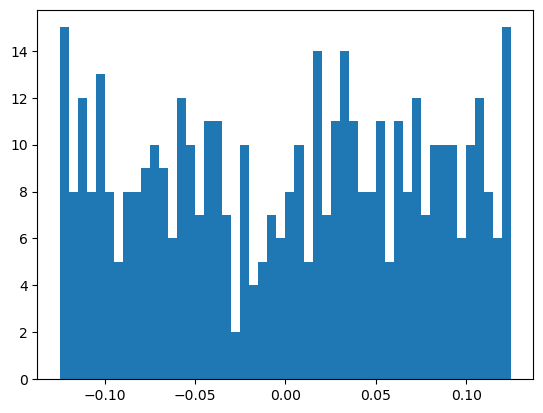

In [14]:
plt.hist(out_w.detach().view(-1), 50);